<a href="https://colab.research.google.com/github/bignamu/python-AI/blob/main/pytorch_Fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Fish 실습

## import module

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_irisifsh  
import torch.nn.functional as F

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## 데이터 준비하기
Pandas를 이용

In [ ]:
path = 'https://raw.githubusercontent.com/bignamu/python-AI/main/DeepLearning/0706_data/Fish.csv' # Fish.csv git 경로

In [ ]:
fish_data = pd.read_csv(path)

In [ ]:
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [ ]:
fish_data.shape

(159, 7)

In [ ]:
fish_data.columns

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')

In [ ]:
fish_data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


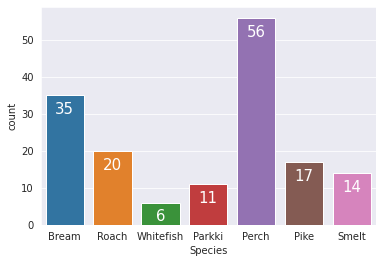

In [ ]:
cntplt = sns.countplot(x = 'Species', data=fish_data)
for p in cntplt.patches:
    cntplt.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+2.9), ha='center', va='top', color='white', size=15)

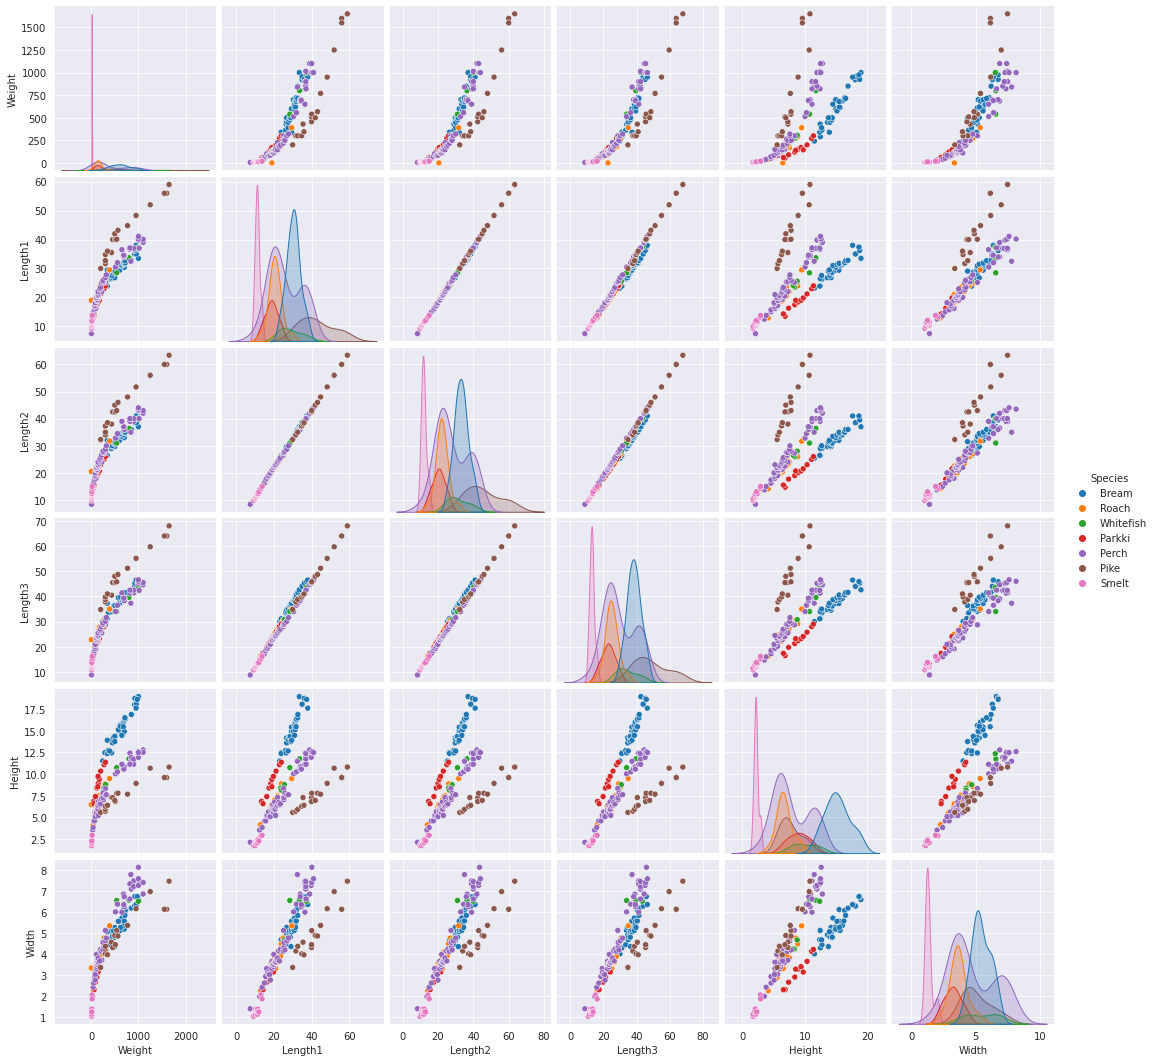

In [ ]:
sns.pairplot(fish_data,hue="Species")

In [ ]:
heatmap_data = fish_data[['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']]

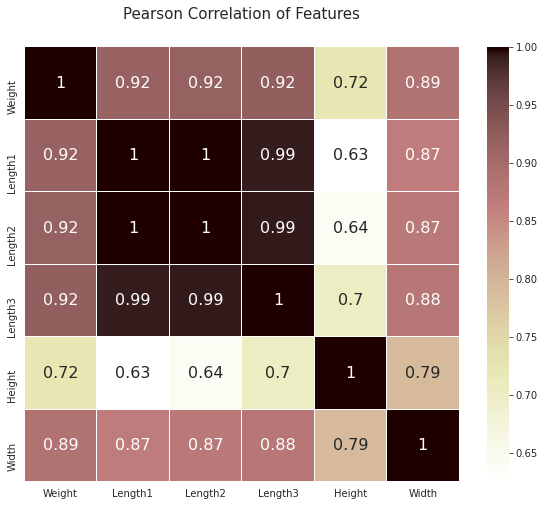

In [ ]:
colormap = plt.cm.pink_r
plt.figure(figsize=(10, 8)) 
plt.title("Pearson Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})


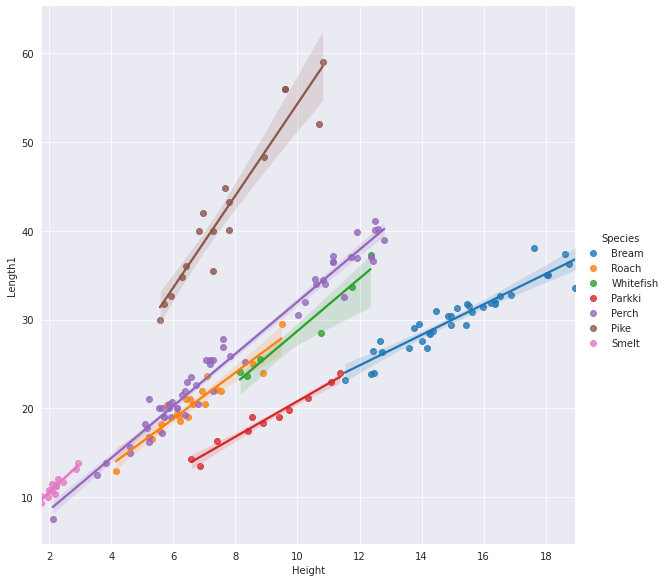

In [ ]:
# sns.jointplot('Weight','Length1',data=fish_data,kind='reg')
sns.lmplot(x="Height", y="Length1", hue="Species", height=8, data=fish_data)

In [ ]:
fish_data2 = pd.get_dummies(fish_data)

In [ ]:
fish_data2.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


In [ ]:
fish_data2.columns

Index(['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width',
       'Species_Bream', 'Species_Parkki', 'Species_Perch', 'Species_Pike',
       'Species_Roach', 'Species_Smelt', 'Species_Whitefish'],
      dtype='object')

In [ ]:
origin_spec = fish_data['Species']

spec = list(set(fish_data['Species']))
spec.sort()
print(spec)
_dict = {}
for idx, fish in enumerate(spec):
  _dict[fish] = idx
print(_dict)

['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish']
{'Bream': 0, 'Parkki': 1, 'Perch': 2, 'Pike': 3, 'Roach': 4, 'Smelt': 5, 'Whitefish': 6}


In [ ]:
fish_data['Species'] = fish_data['Species'].map(_dict)

In [ ]:
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,0,290.0,24.0,26.3,31.2,12.4800,4.3056
2,0,340.0,23.9,26.5,31.1,12.3778,4.6961
3,0,363.0,26.3,29.0,33.5,12.7300,4.4555
4,0,430.0,26.5,29.0,34.0,12.4440,5.1340


## 모델 구조 만들기

### Custom Model

* 데이터의 row와 column에 따라 더 많은 학습은 정확도를 낮추기도 한다
* 히든레이어는 보통 2의 배수로 입력받는다
* BatchNormalization과 Dropout은 과적합을 방지하기위해 사용한다
* CrossEntropy에 Softmax가 포함되어있어 마지막 레이어에 해줄필요없다
* 클래스 변수 겹치지 않게 조심


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(6, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)

        # self.dropout = nn.Dropout(0.7)

        self.fc2 = nn.Linear(64, 7)
        # self.batch_norm2 = nn.BatchNorm1d(256)
        # self.fc3 = nn.Linear(256, 7)
        self.silu = nn.SiLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.silu(x)
        # x = self.dropout(x)


        x = self.fc2(x)
        # x = self.batch_norm2(x)
        # x = self.silu(x)
        # x = self.dropout(x)
        
        # x = self.fc3(x)
        # x = self.silu(x)

        return x

### Custom Dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, xtrain, ytrain, transforms=None):
      self.X = xtrain
      self.y = ytrain
      #self.transform = transforms.Compose([transforms.ToTensor()])



  def __len__(self):
    return len(self.X)


  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    # print(type(X), type(y))
    # X = np.array(X)    
    # y = np.array(y)

    return X, y

In [ ]:
fish_features = fish_data[['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']]
fish_label = fish_data['Species']



fish_features = fish_features.to_numpy()
fish_label = fish_label.to_numpy()
print(fish_features[0], fish_label[0])
print(type(fish_features),type(fish_label))
X_train, X_test, y_train, y_test = train_test_split(
                                                    fish_features,
                                                    fish_label,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=fish_label,
                                                    random_state=0
                                                    )
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()

[242.    23.2   25.4   30.    11.52   4.02] 0
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### batch_size / learning rate / optimizer / stepsize
* batch_size가 클수록 일반화하기 어렵다

In [ ]:
train_dataset = CustomDataset(X_train, y_train, transforms=None)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.1)

In [ ]:
epoch = 1000
total_loss = 0
epoLoss = {}

In [ ]:
print(len(train_loader))
for i in range(epoch):
    total_loss = 0
    for X, y in train_loader:
        X = X.float().to(device)
        y = y.long().to(device)
        # print(X[:5],y[:5])
        # print(X.shape,y.shape)
        # print(X.dim(),y.dim())
        
        outputs = model(X)
        loss = criterion(outputs, y)
        optimizer.zero_grad()# 기울기 초기화
        loss.backward()# 가중치와 편향에 대해 기울기 계산
        total_loss += loss.item()
        optimizer.step()
    epoLoss[i] = total_loss
    
    if i % 900 == 0:
        torch.save(model.state_dict(), f"./model_{i}.pth")
    if i % 100 == 0:
      print(f"epoch -> {i}      loss -- > ", total_loss / len(X_train))


8
epoch -> 0      loss -- >  0.11054508423242043
epoch -> 100      loss -- >  0.030378860751474935
epoch -> 200      loss -- >  0.0235425490797974
epoch -> 300      loss -- >  0.02553993874178158
epoch -> 400      loss -- >  0.03172351959652788
epoch -> 500      loss -- >  0.018182150726243268
epoch -> 600      loss -- >  0.016871869505390408
epoch -> 700      loss -- >  0.015089722654569572
epoch -> 800      loss -- >  0.010099172078835683
epoch -> 900      loss -- >  0.00898634045436157


Text(0.5, 1.0, 'Epoch, Loss')

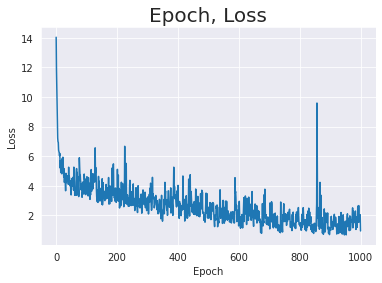

In [ ]:
epolos = sns.lineplot(x=list(epoLoss.keys()), y=list(epoLoss.values()))
epolos.set(xlabel='Epoch',ylabel='Loss')
epolos.set_title('Epoch, Loss',size = 20)

# 모델 평가
* 데이터의 내용에 영향을 받는다
* 만약 암에 관련된 데이터였다면 f1-score가 중요하다
 FP, 암인데 정상이라고 말한다면 미치는 영향력이 매우 클 것

##정확도


In [ ]:
# 평가
model.eval()
model.load_state_dict(torch.load('model_900.pth'))
test_dataset = CustomDataset(X_test, y_test, transforms=None)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
err = 0

In [ ]:
pred_list = []
for t_x, t_y in test_loader:
    t_x = t_x.float().to(device)
    t_y = t_y.long().to(device)
    outputs = model(t_x)
    top = torch.topk(outputs, 1)
    top_index = top.indices.numpy()

    for y, t in zip(t_y, top_index):
        if y != t[0]:
            err += 1
    for idx in top_index:
      pred_list.append(idx[0])
print(f"test acc = {int((len(X_test) - err)/len(X_test)  * 100)}%")


test acc = 90%


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

##f1-score

![f1-score](http://www.popit.kr/wp-content/uploads/2017/04/table-1024x378.png)

In [ ]:
print(classification_report(pred_list,list(y_test)))

              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.00      0.00      0.00         2
           2       0.27      0.30      0.29        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1

    accuracy                           0.16        32
   macro avg       0.08      0.08      0.08        32
weighted avg       0.15      0.16      0.15        32

